# Clever filtering using pytorch Module and optimizer

I didn't have good luck using my own gradient descent so I'm using this as an opportunity to learn the higher level pytorch mechanisms like `torch.nn`. This [tutorial on pytorch](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) is very good.  See work by Jeremy Howard and fastai gang: [dl1/lesson5-movielens.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb) and [fastai book: 08_collab.ipynb](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb).

## Support code

In [1]:
import math
import torch
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def RF_valid(df, movie_embeddings, user_embeddings):
    X = df[['movieId','userId']]
    y = df['rating']
    X_emb = np.concatenate([movie_embeddings[X['movieId']],user_embeddings[X['userId']]], axis=1)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_emb, y)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_emb, y):.3f}")

In [3]:
import pandas as pd
import re

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes # encode 0..n-1
    df[colname] = df[colname].astype(int)
    
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2, device, dtype, mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [4]:
def mae(y_pred, y):
    return torch.mean( (y_pred - y).abs() )

In [5]:
def train_test_split(data, test_size:float):
    n = len(data)
    n_valid = int(n*test_size)
    n_train = n - n_valid
    indices = torch.randperm(n)
    train_idx = indices[0:n_train]
    test_idx = indices[n_train:]
    train, test = data[train_idx], data[test_idx] # copying data but could not get columns out of a Subset object
    # train, valid = data, data
    X_train = train[:,[0,1]].float()
    X_test = test[:,[0,1]].float()
    y_train = train[:,2].float()
    y_test = test[:,2].float()
    return X_train, X_test, y_train, y_test

In [6]:
def top_movies(df, n=100):
    df_movies = df[['movieId','title','genres']].drop_duplicates()
    df_movies = df_movies.set_index('movieId')
    rating_count = df.groupby('movieId').count()
    top_movieIds = rating_count.sort_values(by='rating',ascending=False)[:n].index
    return df_movies.loc[top_movieIds]

In [7]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Rating (0..5.0) MAE")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [170]:
from sklearn.decomposition import PCA

def mcolor(genre):
    if 'Comedy' in genre: return 'green'
    if 'Sci-Fi' in genre: return 'cyan'
    if 'War' in genre: return 'red'
    if 'Drama' in genre: return '#FEE08F'
    return 'black'

def plot_2D(df_movies):
    movieIds = df_movies.index.values
    titles = df_movies.loc[movieIds,'title']

    movie_embeddings = model.M[movieIds].detach().numpy()
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)

    plt.figure(figsize=(12,12))
    for i,title in enumerate(titles[:60]):
        plt.text(vecs2D[i,0], vecs2D[i,1], title)

    plt.scatter(vecs2D[:,0][:60], vecs2D[:,1][:60], s=2)

    plt.xlim(-1.1,2.5)
    plt.ylim(-1.2,1.5)
    plt.show()
    return vecs2D, titles

## Load and train with no mini-batch

In [10]:
df = load(n=100_000)
n = len(df)
nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')
df.head(2)

,userId,movieId,rating,title,genres
0,199,4320,4.0,X2: X-Men United,Action|Adventure|Sci-Fi|Thriller
1,166,4320,4.5,X2: X-Men United,Action|Adventure|Sci-Fi|Thriller


In [11]:
avg_rating = np.mean(df['rating'])
avg_rating

3.501265

In [12]:
import torch.nn as nn

class CollabFilter(nn.Module):
    def __init__(self, nusers, nmovies, nfactors=10, avg_rating=3.5):
        super(CollabFilter, self).__init__()
        self.U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.U = nn.Parameter(self.U) # notify pytorch these are model parameters
        self.M = nn.Parameter(self.M)
        
    def forward(self, x):
        userIds = x[:,0].long()
        movieIds = x[:,1].long()
        r_output = (self.U[userIds] * self.M[movieIds]).sum(axis=1, keepdim=False)
        r_output = torch.sigmoid(r_output) * 5  # limit to 0..5
        return r_output

In [53]:
def train(df, epochs=350, learning_rate = 0.002, nfactors=10, use_bias=False, print_every=30, loss_fn=torch.nn.MSELoss()):    
    data = torch.tensor( df[['userId','movieId','rating']].values )
    X_train, X_valid, y_train, y_valid = train_test_split(data, 0.20)
    print(f"{len(X_train)} training and {len(X_valid)} test records")

    if use_bias:
        model = CollabFilterWithBias(nusers, nmovies, nfactors=nfactors)
    else:
        model = CollabFilter(nusers, nmovies, nfactors=nfactors)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00000002) # model.parameters is just [U,M]

    history = []

    # Start history with what random weights show
    with torch.no_grad():
        loss = loss_fn(model(X_train), y_train)
        loss_valid = loss_fn(model(X_valid), y_valid)
        mae_train = mae(model(X_train), y_train).detach().item()
        mae_valid = mae(model(X_valid), y_valid).detach().item()
    history.append( (loss, loss_valid) )
    print(f"Init      L2 MSE loss {loss:4.3f}, {loss_valid:4.3f}   MAE {mae_train:4.3f}, {mae_valid:4.3f}")

    for t in range(epochs):
        r_pred = model(X_train)
        loss = loss_fn(r_pred, y_train)

        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad and M.grad
        optimizer.step()

        with torch.no_grad():
            loss_valid = loss_fn(model(X_valid), y_valid)
            mae_train = mae(model(X_train), y_train).detach().item()
            mae_valid = mae(model(X_valid), y_valid).detach().item()

        history.append( (loss, loss_valid) )
        if t % print_every == 0:
            print(f"Epoch {t:3d} L2 MSE loss {loss:4.3f}, {loss_valid:4.3f}   MAE {mae_train:4.3f}, {mae_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

80000 training and 20000 test records
Init      L2 MSE loss 2.922, 2.894   MAE 1.392, 1.386
Epoch   0 L2 MSE loss 2.922, 2.848   MAE 1.379, 1.373
Epoch  30 L2 MSE loss 0.930, 0.955   MAE 0.737, 0.761
Epoch  60 L2 MSE loss 0.666, 0.785   MAE 0.617, 0.679
Epoch  90 L2 MSE loss 0.639, 0.788   MAE 0.602, 0.680
Epoch 120 L2 MSE loss 0.631, 0.796   MAE 0.596, 0.683
Epoch 150 L2 MSE loss 0.621, 0.805   MAE 0.590, 0.686
Epoch 180 L2 MSE loss 0.584, 0.812   MAE 0.572, 0.690
Epoch 210 L2 MSE loss 0.497, 0.826   MAE 0.523, 0.695
Epoch 240 L2 MSE loss 0.393, 0.869   MAE 0.458, 0.711
Epoch 270 L2 MSE loss 0.325, 0.932   MAE 0.410, 0.734
Epoch 300 L2 MSE loss 0.288, 0.989   MAE 0.381, 0.754
Epoch 330 L2 MSE loss 0.266, 1.038   MAE 0.362, 0.771


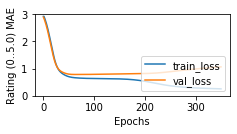

In [69]:
model, history = train(df, epochs=350, learning_rate=.01, nfactors=10)
plot_history(history, yrange=(0,3), figsize=(3.5,1.5))

## Interpretation

### Using embeddings for prediction with random forest

Once we have embeddings, we can try to use them as features in a random forest. The OOB error will give us an indication of how good the embeddings are. When we get a validation MAE of 0.74 from training with n=20,000 and nfactors=10, the RF OOB R^2 is about .45, which is much better than we get using label encoded categorical variables (no better than guessing the mean with about R^2 of 0.0).

In [70]:
RF_valid(df, model.M.detach().cpu(), model.U.detach().cpu())

OOB R^2 0.482
Train R^2 0.929


In [16]:
model, history = train(df, epochs=350, , learning_rate=.01, nfactors=4, print_every=50)
RF_valid(df, model.M.detach().cpu(), model.U.detach().cpu())

80000 training and 20000 test records
Init      L2 MSE loss 2.904, 2.959   MAE 1.388, 1.399
Epoch   0 L2 MSE loss 2.904, 2.953   MAE 1.386, 1.398
Epoch  50 L2 MSE loss 2.516, 2.562   MAE 1.272, 1.285
Epoch 100 L2 MSE loss 1.912, 1.964   MAE 1.073, 1.090
Epoch 150 L2 MSE loss 1.330, 1.399   MAE 0.852, 0.881
Epoch 200 L2 MSE loss 0.995, 1.084   MAE 0.746, 0.784
Epoch 250 L2 MSE loss 0.837, 0.941   MAE 0.690, 0.737
Epoch 300 L2 MSE loss 0.756, 0.872   MAE 0.657, 0.711
OOB R^2 0.349
Train R^2 0.910


In [73]:
model, history = train(df, epochs=350, learning_rate=.01, nfactors=50, print_every=50)
RF_valid(df, model.M.detach().cpu(), model.U.detach().cpu())

80000 training and 20000 test records
Init      L2 MSE loss 2.921, 2.896   MAE 1.392, 1.386
Epoch   0 L2 MSE loss 2.921, 2.787   MAE 1.361, 1.356
Epoch  50 L2 MSE loss 0.637, 0.829   MAE 0.601, 0.693
Epoch 100 L2 MSE loss 0.452, 0.821   MAE 0.493, 0.689
Epoch 150 L2 MSE loss 0.116, 0.900   MAE 0.229, 0.720
Epoch 200 L2 MSE loss 0.047, 0.981   MAE 0.131, 0.751
Epoch 250 L2 MSE loss 0.027, 1.048   MAE 0.091, 0.778
Epoch 300 L2 MSE loss 0.018, 1.104   MAE 0.070, 0.798
OOB R^2 0.466
Train R^2 0.927


### Compare rating vs predicted rating visually

If we plot the known ratings against the predicted ratings, ideally we would see a 45° line. If true rating is 4.0 then we'd want the predicted rating to be 4.0.

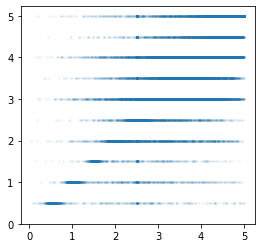

In [74]:
data = torch.tensor( df[['userId','movieId','rating']].values )
plt.figure(figsize=(4.2,4))
plt.scatter(model(data).detach().cpu(), df['rating'], alpha=.05, s=3)
plt.xticks(range(6))
plt.yticks(range(6))
plt.show()

Hmm...hard to interpret, let's try a joint plot!

80000 training and 20000 test records
Init      L2 MSE loss 2.918, 2.902   MAE 1.391, 1.389
Epoch   0 L2 MSE loss 2.918, 2.793   MAE 1.360, 1.359
Epoch  50 L2 MSE loss 0.639, 0.821   MAE 0.602, 0.692
Epoch 100 L2 MSE loss 0.451, 0.812   MAE 0.492, 0.690
Epoch 150 L2 MSE loss 0.115, 0.896   MAE 0.228, 0.723
Epoch 200 L2 MSE loss 0.046, 0.978   MAE 0.130, 0.756
Epoch 250 L2 MSE loss 0.026, 1.039   MAE 0.091, 0.779
Epoch 300 L2 MSE loss 0.017, 1.090   MAE 0.070, 0.798


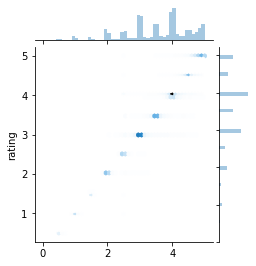

In [75]:
# I learned this jointplot trick from https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb
import seaborn

model, history = train(df, epochs=350, learning_rate=.01, nfactors=50, print_every=50)
seaborn.jointplot(model(data).detach().cpu(), df['rating'], kind='hex', height=3.8)
plt.xticks(range(6))
plt.yticks(range(6))
plt.show()

Try with just 10 factors

80000 training and 20000 test records
Init      L2 MSE loss 2.922, 2.889   MAE 1.392, 1.382
Epoch   0 L2 MSE loss 2.922, 2.843   MAE 1.379, 1.370
Epoch  50 L2 MSE loss 0.697, 0.800   MAE 0.633, 0.688
Epoch 100 L2 MSE loss 0.635, 0.805   MAE 0.598, 0.685
Epoch 150 L2 MSE loss 0.619, 0.822   MAE 0.589, 0.692
Epoch 200 L2 MSE loss 0.527, 0.836   MAE 0.541, 0.698
Epoch 250 L2 MSE loss 0.360, 0.904   MAE 0.437, 0.725
Epoch 300 L2 MSE loss 0.282, 1.002   MAE 0.379, 0.760


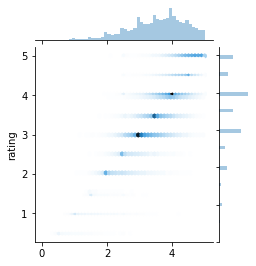

In [67]:
model, history = train(df, epochs=350, learning_rate=.01, nfactors=10, print_every=50)
seaborn.jointplot(model(data).detach().cpu(), df['rating'], kind='hex', height=3.8)
plt.xticks(range(6))
plt.yticks(range(6))
plt.show()

It looks to me like the embedding with 50 dimensions gets a tighter mapping (45° line) than 10 dimensional embedding vectors.

## Model with biases

In [76]:
import torch.nn as nn

class CollabFilterWithBias(nn.Module):
    def __init__(self, nusers, nmovies, nfactors=10, avg_rating=3.5):
        super(CollabFilterWithBias, self).__init__()
        self.U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.U_bias = randn(nusers,  1,        device=device, dtype=dtype, requires_grad=True,
                      std=0.01, mean=avg_rating/nfactors)
        self.M_bias = randn(nmovies, 1,        device=device, dtype=dtype, requires_grad=True,
                      std=0.01, mean=avg_rating/nfactors)
        # Indexing is tricky; took me a while to interpret everything properly for visualization
        # The movie and user IDs are used as indexes into the U, M, and bias tensors so they are
        # inherently ordered by move or user ID. M_bias[13] is the bias for movie ID 13
        self.U = nn.Parameter(self.U) # notify pytorch these are model parameters
        self.M = nn.Parameter(self.M)
        self.U_bias = nn.Parameter(self.U_bias)
        self.M_bias = nn.Parameter(self.M_bias)
        
    def forward(self, x):
        userIds = x[:,0].long()
        movieIds = x[:,1].long()
        r_output = (self.U[userIds] * self.M[movieIds]).sum(axis=1)
        bias = (self.U_bias[userIds] + self.M_bias[movieIds]).reshape(len(x))
        r_output = r_output
        r_output += bias
        r_output = torch.sigmoid(r_output) * 5  # limit to 0..5
        return r_output

80000 training and 20000 test records
Init      L2 MSE loss 2.968, 2.962   MAE 1.405, 1.401
Epoch   0 L2 MSE loss 2.968, 2.857   MAE 1.376, 1.372
Epoch  50 L2 MSE loss 0.606, 0.805   MAE 0.589, 0.688
Epoch 100 L2 MSE loss 0.430, 0.785   MAE 0.481, 0.678
Epoch 150 L2 MSE loss 0.119, 0.859   MAE 0.232, 0.707
Epoch 200 L2 MSE loss 0.048, 0.934   MAE 0.132, 0.738
Epoch 250 L2 MSE loss 0.027, 0.998   MAE 0.092, 0.763
Epoch 300 L2 MSE loss 0.018, 1.050   MAE 0.070, 0.782
Epoch 350 L2 MSE loss 0.013, 1.095   MAE 0.057, 0.798


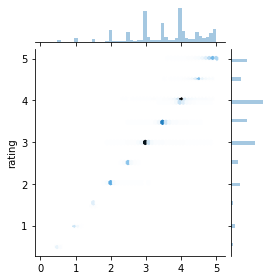

In [77]:
model, history = train(df, epochs=400, learning_rate = 0.01, nfactors=50, use_bias=True, print_every=50)
g = seaborn.jointplot(model(data).detach().cpu(), df['rating'], kind='hex', height=4)
plt.show()

Another trick from fastai book is to look at biases. Each movie (and each user) has a bias value computed during training. The movie bias adjusts the rating computed from the dot product of a movie and user in the training set to get it closer to the known rating. Let's start by looking at the top movies sorted by overall rating. Note that this rating does not say how good a movie is per se. It says: of those that have (self filtered to have) seen this movie, how did they rate the movie?

In [89]:
topN = 2_000
df_top_movies = top_movies(df, n=topN)
df_top_movies.head(3)

,title,genres
movieId,,
313,Forrest Gump,Comedy|Drama|Romance|War
276,"Shawshank Redemption, The",Crime|Drama
256,Pulp Fiction,Comedy|Crime|Drama|Thriller


The top rated movie is Forrest Gump. The people that have seen it seemed to really like it. It doesn't say that the features of the movie would in any way overlap with anySpecific individual's interests, however.

In [84]:
len(df_top_movies), model.M.shape, model.M_bias.shape

(2000, torch.Size([9695, 50]), torch.Size([9695, 1]))

In [85]:
# M_bias at i is movie ID i
df_top_movies['movie_bias'] = model.M_bias[df_top_movies.index.values].detach().numpy()
df_top_movies.head(5)

,title,genres,movie_bias
movieId,,,
313,Forrest Gump,Comedy|Drama|Romance|War,0.335630
276,"Shawshank Redemption, The",Crime|Drama,0.516217
256,Pulp Fiction,Comedy|Crime|Drama|Thriller,0.366138
508,"Silence of the Lambs, The",Crime|Horror|Thriller,0.062863
1936,"Matrix, The",Action|Sci-Fi|Thriller,0.061423


In [86]:
df_top_movies.sort_values('movie_bias', ascending=True).head(8)

,title,genres,movie_bias
movieId,,,
635,Kazaam,Children|Comedy|Fantasy,-0.959063
229,Major Payne,Comedy,-0.871816
394,Free Willy,Adventure|Children|Drama,-0.781908
593,Barb Wire,Action|Sci-Fi,-0.764889
495,"Little Rascals, The",Children|Comedy,-0.735177
1099,Beverly Hills Ninja,Action|Comedy,-0.733979
2454,Scream 3,Comedy|Horror|Mystery|Thriller,-0.719775
7148,2012,Action|Drama|Sci-Fi|Thriller,-0.690927


"Pride and Prejudice" (for this run) seems to have the most negative bias, meaning that to match the ratings given by the users for this movie, the model had to downward shift the rating predicted by overlap of interests.

In [87]:
df_top_movies.sort_values('movie_bias', ascending=False).head(8)

,title,genres,movie_bias
movieId,,,
1931,"King and I, The",Drama|Musical|Romance,0.815991
8642,Star Wars: Episode VII - The Force Awakens,Action|Adventure|Fantasy|Sci-Fi|IMAX,0.756390
8836,The Martian,Adventure|Drama|Sci-Fi,0.718231
5922,Serenity,Action|Adventure|Sci-Fi,0.694283
1155,"Fifth Element, The",Action|Adventure|Comedy|Sci-Fi,0.675229
693,"Maltese Falcon, The",Film-Noir|Mystery,0.667944
9558,Blade Runner 2049,Sci-Fi,0.654038
1795,Miracle on 34th Street,Comedy|Drama,0.652110


"The King and I" apparently gets a boost to indicate people like it.

The fastai book points out quite nicely that movies with very negative biases mean that people don't like them, even when the movie x user dot product gives the movie a high score (a high score indicates they are likely to enjoy that movie based on the latent features).  For the really positive bias movies, such as 0.9593 bias, that indicates that even if the movie is not a good fit for you, you might like it because it gives you almost a full star boost because it is that good. Of course, it is also the case that poorly matched movies with low bias predicts a really bad experience watching the movie.  Naturally we should recommend to people movies that have both high product and high bias.

### Project 50D embeddings onto 2D

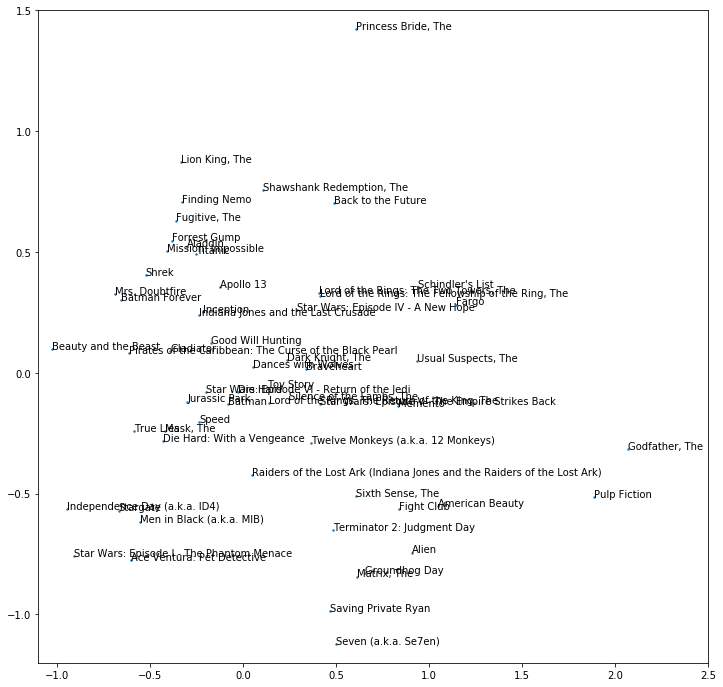

In [164]:
vecs2D, titles = plot_2D(df_top_movies[:500])

We can see that the Lord of the rings movies are more or less right on top of each other and so are the Star Wars movies.

In [191]:
movieIds = df_top_movies[:500].index.values
titles = df_top_movies.loc[movieIds,'title']

movie_embeddings = model.M[movieIds].detach().numpy()
pca = PCA(n_components=3) # <-- 3 not 2
vecs2D = pca.fit_transform(movie_embeddings)
df_sort = df_top_movies[:500].copy()
df_sort['f1'] = vecs2D[:,0]
df_sort['f2'] = vecs2D[:,1]
df_sort['f3'] = vecs2D[:,2]
df_sort

,title,genres,f1,f2,f3
movieId,,,,,
313,Forrest Gump,Comedy|Drama|Romance|War,-0.381892,0.547383,-0.466326
276,"Shawshank Redemption, The",Crime|Drama,0.104641,0.757234,-0.471040
256,Pulp Fiction,Comedy|Crime|Drama|Thriller,1.887290,-0.513050,0.483246
508,"Silence of the Lambs, The",Crime|Horror|Thriller,0.247241,-0.109192,0.646543
1936,"Matrix, The",Action|Sci-Fi|Thriller,0.614378,-0.843724,0.343021
...,...,...,...,...,...
2797,"Me, Myself & Irene",Adventure|Comedy,-0.605645,0.095400,-0.290444
7286,Iron Man 2,Action|Adventure|Sci-Fi|Thriller|IMAX,-0.639909,-0.100282,0.269159
6886,Gran Torino,Crime|Drama,0.518254,0.408897,-0.349220


Sort movies by the projected dimension. It looks like the first dimension is a spectrum of maybe adventure on one side and crime on the other.  The second dimension might be action versus romance comedy. I don't see a pattern for the third dimension.

In [198]:
df_sort.sort_values(by='f1')[['title','genres']]

,title,genres
movieId,,
2026,Wild Wild West,Action|Comedy|Sci-Fi|Western
4062,Harry Potter and the Chamber of Secrets,Adventure|Fantasy
1168,Con Air,Action|Adventure|Thriller
1969,"Mummy, The",Action|Adventure|Comedy|Fantasy|Horror|Thriller
183,Billy Madison,Comedy
...,...,...
904,"Clockwork Orange, A",Crime|Drama|Sci-Fi|Thriller
256,Pulp Fiction,Comedy|Crime|Drama|Thriller
898,Brazil,Fantasy|Sci-Fi


In [199]:
df_sort.sort_values(by='f2')[['title','genres']]

,title,genres
movieId,,
1295,"Big Lebowski, The",Comedy|Crime
1258,Starship Troopers,Action|Sci-Fi
2632,American Psycho,Crime|Horror|Mystery|Thriller
1620,Blade,Action|Horror|Thriller
1043,Sling Blade,Drama
...,...,...
6208,Little Miss Sunshine,Adventure|Comedy|Drama
688,North by Northwest,Action|Adventure|Mystery|Romance|Thriller
896,"Princess Bride, The",Action|Adventure|Comedy|Fantasy|Romance


In [200]:
df_sort.sort_values(by='f3')[['title','genres']]

,title,genres
movieId,,
310,"Crow, The",Action|Crime|Fantasy|Thriller
3223,A.I. Artificial Intelligence,Adventure|Drama|Sci-Fi
2972,Unbreakable,Drama|Sci-Fi
3000,"O Brother, Where Art Thou?",Adventure|Comedy|Crime
3006,Traffic,Crime|Drama|Thriller
...,...,...
7317,Toy Story 3,Adventure|Animation|Children|Comedy|Fantasy|IMAX
984,This Is Spinal Tap,Comedy
1258,Starship Troopers,Action|Sci-Fi


## Lessons

Make sure that you have a valid way to assess your model before you start. I spent many hours chasing a bad model that in fact was simply a bad assessment.

With about 10,000 movies, most of them you will not of heard of. So if you try to show a PCA projection or top bias movies or something like that, you will likely see a bunch of movies you don't know. I dropped it down to 2000 for visualization purposes but not training.

It seems that driving the training score very low gives me a much tighter joint plot; this is despite the fact that the validation error was going up.